## Part_3

### 0. Import Libraries.

In [1]:
import numpy as np
import pandas as pd

import yfinance as yf
import finta


import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import gc; gc.enable()

from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline, make_union
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split,cross_validate

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer

from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report


from scipy.signal import argrelextrema
from scipy.signal import savgol_filter

from sklearn.model_selection import StratifiedKFold

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from category_encoders import WOEEncoder, TargetEncoder
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

### 1. Define Helper Functions.

In [24]:
def smooth(series):
    '''
    This function smoothes target/close price. 
    '''
    series = savgol_filter(series, 21, 2)
    series = savgol_filter(series, 11, 2)
    series = savgol_filter(series, 11, 1)
    return series
    
def loc_minima(series, order=10):
    '''
    Function returns pandas series with values 1&0: if local minima = 1, otherwise = 0.
    Where,
    series: e.g. = df.close
    order: number of days(both sides) of the local minimum point.
    
    '''
    # get the indeces of local minima with specified order(number of days from local min)
    local_min = argrelextrema(series.values, np.less_equal, order=order)[0].tolist()
    
    # get pandas series with 0s.
    min_series = 0*series
    
    # update series by assigning 1s to local minima(using list of indeces: local_min) 
    min_series[local_min] = 1
    
    gc.collect()
    return min_series

def loc_maxima(series, order=10):
    '''
    Function returns pandas series with values 1&0: if local maxima = 1, otherwise = 0.
    Where,
    series: e.g. = df.close
    order: number of days(both sides) of the local maximum point.
    
    '''
    
    # get the indeces of local maxima with specified order(number of days from local max)
    local_max = argrelextrema(series.values, np.greater_equal, order=order)[0].tolist()
    
    # get pandas series with 0s.
    max_series = 0*series
    
    # update series by assigning 1s to local maxima(using list of indeces: local_max) 
    max_series[local_max] = 1

    gc.collect()
    return max_series

def loc_extrema(series, order=10):
    
    '''
    Function returns pandas series with values 0,1,-1: 
    if local minima = 1, if local maxima = -1, otherwise = 0.
    
    Where,
    series: e.g. = df.close
    order: number of days(both sides) of the local extremum point.
    
    '''
    loc_max = loc_maxima(series,order)
    loc_min = loc_minima(series,order)
    return loc_min - loc_max

def calc_slope(x):
    '''
    Function calculates 'slope' of x
    '''
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

def calc_acc(x):
    '''
    Function calculates 'acceleration' of x
    '''
    acc = np.polyfit(range(len(x)), x, 2)[0]
    return acc


def col_rename(data):
    '''
    Function renames columns.
    '''
    data.dropna(inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])
    data.sort_values(by='Date',inplace=True)
    data.set_index('Date',inplace=True)
    data.index.rename('date',inplace=True)
    data.rename(str.lower, axis='columns',inplace=True)
    data.rename(columns={"stock splits": "stock_splits"},inplace=True)
    #data.columns = ['close', 'dividends', 'high', 'low','open','stock_splits','ticker','volume']
    return data

def split_check(data):
    '''
    No splits returns True
    if splits return False
    '''
    if len(data.stock_splits.unique())==1 and data.stock_splits.unique()[0]==False:
        return True
    else:
        return False

def reduce_df(data):
    '''
    Returns reduced data frame.
    '''
    data = col_rename(data) # renames columns
    
    try:
        data = data[['ticker','open','high','low','close','volume']]
        return data
    except:
        print('Error occured!')
    
    
def display(data,x=5,y=5):
    '''
    Function shows head and tail of data frame.
    '''
    return data.head(x).append(data.tail(y))

def plot(data, size = (18,6),title='Plot',legend=True):
    '''
    plots dataFrame or dataSeries
    '''
    #plt.figure(figsize=size)
    data.plot(title=title,legend=legend,figsize=size)
    plt.show()
    
def plot_df(df, columns, size = (18,8), scale = 10*[1]):
    
    '''
    Plots dataFrame or dataSeries.
    '''

    #plt.style.use('fivethirtyeight')
    plt.style.use('seaborn-darkgrid')

    # create a color palette
    palette = plt.get_cmap('tab10')

    plt.figure(figsize=size)

    #multiple line plot
    #plot main line
    plt.plot(df.index, scale[0]*df[columns[0]], marker='', color='blue', linewidth=3,
             alpha=1, label = columns[0], linestyle='solid')
    
    #plot secondary lines
    num=0
    for col in df[columns].drop(columns[0], axis=1):
        num+=1
        plt.plot(df.index, scale[num]*df[col], marker='', color=palette(num), linewidth=1, 
                 alpha=0.7, label=col, linestyle='solid') #markersize=1


    # Add legend
    plt.legend()

    # Change xlim
    #plt.xlim(0,12)

    # Add titles
    plt.title("Plot", fontsize=20, fontweight=3, color='black')
    plt.xlabel("Date",fontsize=14, fontweight=3, color='black')
    plt.ylabel("Close Price",fontsize=14, fontweight=3, color='black')
    plt.show()

    
def add_features(df):
    
    '''
    Function returns data frame with features.
    '''
       
    ##### Prepare columns for finta module https://pypi.org/project/finta/
    ohlc = ['open', 'high', 'low', 'close']
    ohlcv = ['open', 'high', 'low', 'close', 'volume']
    
    df_accum = pd.DataFrame()

    
    ##### Loop through
    for ticker in df['ticker'].unique():
        
        df_tmp = df.loc[df["ticker"]==ticker]

        ##### Get close price change for 1-15, 20, 25, 30 days ago

        # Percentage change between the current and a prior closing price
        # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html

        # Compare percentage change of today's price refernce to price of'lag' day ago
        lags = list(range(1,16))+[20,25,30]
        for i in lags:
            df_tmp[f'pct_lag_{i}']=df_tmp['close'].pct_change(periods=i)



        ##### Get the rolling mean and std deviation of pct_change

        # Compare percentage change of today's price refernce to price'lag' day ago
        lags = [1,5,10,15,10] 

        # Rolling windows = 5,10,15,20 days
        windows = [5,10,15,20] 
        for i in lags:
            for window in windows:
                df_tmp[f'pct_r_mean_{i}_{window}'] = df_tmp[f'pct_lag_{i}'].rolling(window).mean()
                df_tmp[f'pct_r_std_{i}_{window}'] = df_tmp[f'pct_lag_{i}'].rolling(window).std()


        ##### Get the exponential mean and std deviation of pct_change
        # finta.TA.EMA(df[ohlc],period=5) is the same df.close.ewm(span = 5).mean()

        # use pct_lag_1 here
        # use span = 5 and 10 periods or alpha = 2/(span+1)  (period is not the same as day)        
        df_tmp['pct_exp_mean_1_5'] = df_tmp['pct_lag_1'].ewm(span=5).mean()
        df_tmp['pct_exp_std_1_5'] = df_tmp['pct_lag_1'].ewm(span=5).std()

        df_tmp['pct_exp_mean_1_10'] = df_tmp['pct_lag_1'].ewm(span=10).mean()
        df_tmp['pct_exp_std_1_10'] = df_tmp['pct_lag_1'].ewm(span=10).std()


        ##### Get 'Direction'='MACD' - 'Signal'

        # MACD= 12_Period EMA − 26_Period EMA
        # https://www.investopedia.com/terms/m/macd.asp
        # df.close.ewm(span=12).mean()-df.close.ewm(span=26).mean() is the same as:
        # finta.TA.MACD(df[ohlc]), also returns 9 day signal line

        df_tmp['macd'] = (df_tmp.close.ewm(span=12).mean()-df_tmp.close.ewm(span=26).mean())

        # signal line is 9 period EMA of the MACD line
        df_tmp['signal']= df_tmp['macd'].ewm(span=9).mean()

        # diffrence between MACD and Signal line indicates bullish
        # or bearish direction of the market
        df_tmp['direction'] = df_tmp['macd']-df_tmp['signal']


        ##### Get 'slope' and 'acceleration'                          
        df_tmp['slope'] = df_tmp.close.rolling(9).apply(calc_slope,raw=False)
        df_tmp['acc'] = df_tmp.close.rolling(11).apply(calc_acc,raw=False)


        ### Get parabolic sar: 'stop and reverse'
        # https://www.investopedia.com/trading/introduction-to-parabolic-sar/
        # e.g value of af = 0.01  could keep in position longer time 
        df_tmp['sar'] = finta.TA.SAR(df_tmp[ohlc].copy(), af=0.025, amax=0.15)# not use as feature, plot only  

        # get normalized sar as signal: 
        #if 0<norm<1 then uptrend, if norm < 0, downtrend
        # here is an imballance possible, however as we do two separate models, 
        # for min and max target, may need to adjust
        df_tmp['sar_norm'] = 1- df_tmp.sar/df_tmp.close

        # do the same for moving avg 50,100,150,200
        windows=[50,100,150,200]

        # get normalized rolling_mean as signal: if 0<norm<1 then uptrend, if norm < 0, downtrend
        # here is an imballance possible, however as we do two separate models, 
        # for min and max target
        for win in windows: 
            df_tmp[f'r_mean_{win}'] = df_tmp.close.rolling(win).mean() # not use as feature, plot only
            df_tmp[f'r_mean_{win}_norm'] = 1 - df_tmp[f'r_mean_{win}']/df_tmp.close

        # macd: if short moving avg > long moving avg 
        # normalize: divide by short moving avg, and if 0<norm<1 then uptrend, if norm < 0, downtrend

        df_tmp[f'macd_50_100_norm'] = 1 - df_tmp[f'r_mean_100']/df_tmp[f'r_mean_50']
        df_tmp[f'macd_50_150_norm'] = 1 - df_tmp[f'r_mean_150']/df_tmp[f'r_mean_50']
        df_tmp[f'macd_50_200_norm'] = 1 - df_tmp[f'r_mean_200']/df_tmp[f'r_mean_50']
        df_tmp[f'macd_100_200_norm'] = 1 - df_tmp[f'r_mean_200']/df_tmp[f'r_mean_100']


        ### Get ADX: Average Directional Index
        # The A.D.X. is 100 * smoothed moving average of absolute value (DMI +/-) 
        # divided by (DMI+ + DMI-). ADX does not indicate trend direction or momentum,
        # only trend strength.
        # Here I normalised by dividing 30(assumed here above 30 is moderately strong trend).
        # https://www.investopedia.com/terms/a/adx.asp
        df_tmp['adx'] = (finta.TA.ADX(df_tmp[ohlc].copy(), period=14))/30


        ### Get RSI relative strength index is a momentum indicator
        # https://www.investopedia.com/terms/r/rsi.asp
        df_tmp['rsi'] = finta.TA.RSI(df_tmp[ohlc].copy(), period=14)
        
#         df_tmp['vwap'] = finta.TA.VWAP(df_tmp[ohlcv].copy())
        
        ### add_targets
        # get local minima and maxima (10 days both side from local extrema)
        df_tmp['target_min'] = loc_minima(df_tmp.close,order=10)
        df_tmp['target_max'] = loc_maxima(df_tmp.close,order=10)

        # get local extrema, its the same as above, just for plotting purpose
        # local minima(=1) and maxima(=-1)
        df_tmp['extrema'] = loc_extrema(df_tmp.close,order=10)

        #df_tmp.dropna(inplace=True)
        
        df_accum = pd.concat([df_accum,df_tmp],sort='False')

    df_accum.dropna(inplace=True)
    df_accum.sort_values(by='date',inplace=True)
    gc.collect()
    
    return df_accum


def roi_calc(data):
    
    '''
    Function calculates ROI for each stock ticker.
    Returns two dataframes: 
    - ROI for each stock for all test period.
    - DF with positions in and out.
    '''
    
    data = data[['ticker','open','high','low','close','predicted']]
    data['pos_in']= data['predicted']
    data['pos_out'] = 0
    data['roi']=1
    data.fillna(0,inplace=True)


    t_stop = -0.045 #### trail stop loss 4.5%
    h_stop = 0.95 # hard stop loss 5% per initial buy

    # create empty data frame, will use for assemble back all stock tickers
    concat_all_df = pd.DataFrame()

    #loop thru each ticker as df-s
    for tick in data['ticker'].unique():

        # create data frame for each stock ticker
        ticker_df = data.loc[data['ticker']==tick]

        # reset indeces
        ticker_df.reset_index(inplace=True)

        # index of the first position_in=1
        first_idx = ticker_df.loc[ticker_df['pos_in']==1].index[0]

        # start df with first in_position = 1
        ticker_df = ticker_df[first_idx:]

        # fix indeces
        ticker_df.reset_index(inplace=True)
        del ticker_df['index']

        # get the list of  all position_in global indeces for one ticker,
        # e.g., for 'BMY'.
        idx_pos_in = ticker_df.loc[ticker_df.pos_in ==1].index.tolist()

        # add the last index to the list if it is not in_postion
        if (len(ticker_df)-1) not in idx_pos_in:
            idx_pos_in.append(len(ticker_df)-1)

        # create empty data frame, will use for assemble back
        concat_df = pd.DataFrame()

        # loop thru all indeces of the list( which is indeces of postion_in) 
        # for one ticker/symbol, e.g. 'BMY'
        for i in range(len(idx_pos_in)):

            # to avoid out of range for the last section of position_in 
            # till the end of the data frame 
            if i < len(idx_pos_in)-1:

                # start slicing the data frame of one ticker for multiple dataframes, 
                # based on the position_in, end - start is delta 
                # between one postion_in and next position_in
                start = idx_pos_in[i] # global index of position_in
                end = idx_pos_in[i+1] # global index of next position_in

                # create a copy of a sub data frame(from one position_in till next position_in )
                tmp = ticker_df.loc[start:end].copy() 

                # create trailing loss column
                tmp['pct_loss'] = tmp['close'].pct_change()

                # fill NaN (created after pct_change) with 0
                tmp.fillna(0,inplace=True)

                # loop inside this sub data frame by indeces (j = index)
                for j in range(start, end+1):

                    # hard loss today(today means at global index j)
                    h_loss = tmp['close'][j]/tmp['close'][start]
                    # trail loss today
                    t_loss = tmp['pct_loss'][j] 

                    # define if need to stop; 
                    # e.g., h_loss = 0.95 or t_loss = -0.07 reqire to stop
                    # as it excced limit specified above as h_stop and t_stopp
                    if h_loss <= h_stop or t_loss <= t_stop:

                        # assign to postion_out 1 as we exceeded allowed stop loss
                        tmp.loc[j,'pos_out']=1

                        # assign to ROI current h_loss, as it is equal to ROI
                        tmp.loc[j,'roi'] = h_loss

                        # break for 'j' loop
                        break

                    # if we didnt exceed any loss stops, than last 
                    # position_out = position_in=1
                    # than means we exit postion and enter it again with the same closed price
                    # its 'fake' position close
                    if j==(end):
                        tmp.loc[j,'pos_out']=1
                        tmp.loc[j,'roi'] = h_loss

                # remove first row of the sub data frame, starting from the second
                if i>0:
                    tmp = tmp[1:]
                concat_df = pd.concat([concat_df,tmp],join='outer')

        concat_df['roi_cumprod']=concat_df['roi'].cumprod()
        
        # dataframe with all data, including roi for each stock
        concat_all_df = pd.concat([concat_all_df,concat_df],join='outer')
    
    del concat_df, tmp
    gc.collect()
    
    roi_all_df = concat_all_df.groupby('ticker')['roi_cumprod'].agg(['last'])
    roi_all_df.columns=['roi']
    
    return roi_all_df, concat_all_df

def calc_sar(data):
    '''
    This function returns ROI using SAR for each stock-ticker.
    '''
    ohlc= ['open', 'high', 'low', 'close']
    data = data[ohlc+['ticker']]


    # create empty data frame, will use for assemble back all stock tickers
    all_sar_data= pd.DataFrame()

    #loop thru each ticker as df-s
    for tick in data['ticker'].unique():
        # create data frame for each stock ticker
        ticker_df = data.loc[data['ticker']==tick]

        # typically af=0.01 for stocks and af=0.02 for currencies (forex)
        # but pennies and small-caps behaviour is closer to currencies than stocks
        # https://www.investopedia.com/trading/introduction-to-parabolic-sar/

        ticker_df['sar'] = finta.TA.SAR(ticker_df[ohlc], af=0.025, amax=0.15) 
        # e.g value of af = 0.01  could keep in position longer time 

        ticker_df['position'] = (ticker_df.sar < ticker_df.close).astype(np.int)

        #https://www.investopedia.com/terms/a/adx.asp
        ticker_df['adx'] = (finta.TA.ADX(ticker_df[ohlc], 14))/30

        ticker_df['region'] = (ticker_df.position != ticker_df.position.shift()).cumsum()

        stats = ticker_df.loc[ticker_df.position == 1].groupby(['ticker','region'])[['close']].agg(['first', 'last', 'count'])
        stats.columns = ['opened', 'closed', 'days']

        # Return on investment
        stats['roi'] = stats.closed / stats.opened 

        # Profits & Losses
        stats['pnl'] = stats.roi - 1.0

        # Profits at a fixed amount - trading without reinvestment
        stats['pnl_cumulat'] = stats['pnl'].cumsum()

        # Profits at 100% portfolio value - trading with 100% reinvestment
        stats['roi_compound'] = stats['roi'].cumprod()
        stats = stats[-1:]


        # dataframe with all data, including roi for each stock
        all_sar_data = pd.concat([all_sar_data,stats],join='outer')

        del ticker_df, stats
        gc.collect()
    all_sar_data.reset_index(inplace=True)
    
    return all_sar_data

### 2. Get and prepare data.
### 2.1. Get from stock_500_full.csv.

In [4]:
df = pd.read_csv('stocks_500_full.csv')
df = reduce_df(df)
df

,ticker,open,high,low,close,volume
date,,,,,,
2010-05-19,BMY,16.99,17.27,16.88,17.17,16424000.0
2010-05-19,OHI,9.28,9.48,9.07,9.38,1532600.0
2010-05-19,EVRG,15.68,15.73,15.36,15.47,1529300.0
2010-05-19,GRMN,22.04,23.29,21.97,22.80,2383000.0
2010-05-19,ALE,24.88,25.14,24.53,24.79,154800.0
...,...,...,...,...,...,...
2020-05-18,EXC,36.32,37.84,36.02,37.54,6307400.0
2020-05-18,VTR,29.18,32.57,29.13,32.26,5177100.0
2020-05-18,NTES,385.00,385.98,374.01,381.88,656136.0


In [5]:
# leave only stock tickers which have data from 2010 and till 2020-05-18 
start_list = df['2010'].ticker.unique().tolist()
df = df.loc[df.ticker.isin(start_list)]

end_list = df['2020-05-18':].ticker.unique().tolist()
df = df.loc[df.ticker.isin(end_list)]

In [6]:
df.ticker.nunique()

409

In [7]:
df

,ticker,open,high,low,close,volume
date,,,,,,
2010-05-19,BMY,16.99,17.27,16.88,17.17,16424000.0
2010-05-19,OHI,9.28,9.48,9.07,9.38,1532600.0
2010-05-19,EVRG,15.68,15.73,15.36,15.47,1529300.0
2010-05-19,GRMN,22.04,23.29,21.97,22.80,2383000.0
2010-05-19,ALE,24.88,25.14,24.53,24.79,154800.0
...,...,...,...,...,...,...
2020-05-18,VZ,55.65,56.20,55.04,55.72,12197445.0
2020-05-18,EXC,36.32,37.84,36.02,37.54,6307400.0
2020-05-18,VTR,29.18,32.57,29.13,32.26,5177100.0


In [8]:
df.describe()

,open,high,low,close,volume
count,1.029067e+06,1.029067e+06,1.029067e+06,1.029067e+06,1.029067e+06
mean,6.727025e+01,6.800579e+01,6.652790e+01,6.729009e+01,3.365059e+06
std,1.507440e+02,1.524795e+02,1.490433e+02,1.508123e+02,8.805755e+06
min,6.400000e-01,6.700000e-01,6.000000e-01,6.300000e-01,0.000000e+00
25%,1.950000e+01,1.973000e+01,1.927000e+01,1.950000e+01,3.502000e+05
50%,3.627000e+01,3.665000e+01,3.589000e+01,3.628000e+01,1.055900e+06
75%,6.608000e+01,6.675000e+01,6.541000e+01,6.610000e+01,2.918500e+06
max,4.025000e+03,4.071130e+03,3.986950e+03,4.037770e+03,6.166205e+08


### 2.2. Get 3 stocks for analysis.

In [10]:
shares_3=['BMY','OHI','EVRG']
df_3 = df.loc[df['ticker'].isin(shares_3)]
df_3.ticker.unique()

array(['BMY', 'OHI', 'EVRG'], dtype=object)

### 2.3. Get S&P 500 index for analysis.

In [11]:
snp = pd.read_csv('snp500.csv')
snp = reduce_df(snp)
snp

,ticker,open,high,low,close,volume
date,,,,,,
2010-05-24,^GSPC,1084.78,1089.95,1072.70,1073.65,5224040000
2010-05-25,^GSPC,1067.42,1074.75,1040.78,1074.03,7329580000
2010-05-26,^GSPC,1075.51,1090.75,1065.59,1067.95,4521050000
2010-05-27,^GSPC,1074.27,1103.52,1074.27,1103.06,5698460000
2010-05-28,^GSPC,1102.59,1102.59,1084.78,1089.41,4871210000
...,...,...,...,...,...,...
2020-05-18,^GSPC,2913.86,2968.09,2913.86,2953.91,6364290000
2020-05-19,^GSPC,2948.59,2964.21,2922.35,2922.94,4969330000
2020-05-20,^GSPC,2953.63,2980.29,2953.63,2971.61,4992970000


### 3. Add features to data frame- df_3 and snp.

In [12]:
df_3 = add_features(df_3)
snp = add_features(snp)

In [13]:
df_3.columns

Index(['acc', 'adx', 'close', 'direction', 'extrema', 'high', 'low', 'macd',
       'macd_100_200_norm', 'macd_50_100_norm', 'macd_50_150_norm',
       'macd_50_200_norm', 'open', 'pct_exp_mean_1_10', 'pct_exp_mean_1_5',
       'pct_exp_std_1_10', 'pct_exp_std_1_5', 'pct_lag_1', 'pct_lag_10',
       'pct_lag_11', 'pct_lag_12', 'pct_lag_13', 'pct_lag_14', 'pct_lag_15',
       'pct_lag_2', 'pct_lag_20', 'pct_lag_25', 'pct_lag_3', 'pct_lag_30',
       'pct_lag_4', 'pct_lag_5', 'pct_lag_6', 'pct_lag_7', 'pct_lag_8',
       'pct_lag_9', 'pct_r_mean_10_10', 'pct_r_mean_10_15', 'pct_r_mean_10_20',
       'pct_r_mean_10_5', 'pct_r_mean_15_10', 'pct_r_mean_15_15',
       'pct_r_mean_15_20', 'pct_r_mean_15_5', 'pct_r_mean_1_10',
       'pct_r_mean_1_15', 'pct_r_mean_1_20', 'pct_r_mean_1_5',
       'pct_r_mean_5_10', 'pct_r_mean_5_15', 'pct_r_mean_5_20',
       'pct_r_mean_5_5', 'pct_r_std_10_10', 'pct_r_std_10_15',
       'pct_r_std_10_20', 'pct_r_std_10_5', 'pct_r_std_15_10',
       'pct_r_std_

In [14]:
display(snp,3,3)

,acc,adx,close,direction,extrema,high,low,macd,macd_100_200_norm,macd_50_100_norm,...,r_mean_50_norm,rsi,sar,sar_norm,signal,slope,target_max,target_min,ticker,volume
date,,,,,,,,,,,,,,,,,,,,,
2011-03-08,-0.061200,0.760854,1321.82,-2.472337,0.0,1325.74,1306.86,5.244644,0.061702,0.035277,...,0.017358,52.505082,1297.966950,0.018046,7.716982,0.768833,0.0,0.0,^GSPC,4531420000
2011-03-09,-0.188240,0.729554,1320.02,-2.196815,0.0,1323.21,1312.27,4.970963,0.061814,0.035080,...,0.015071,51.180036,1299.682603,0.015407,7.167778,0.077833,0.0,0.0,^GSPC,3709520000
2011-03-10,-0.543427,0.752665,1295.11,-3.564007,0.0,1315.72,1294.21,2.712769,0.061822,0.034709,...,-0.004438,36.479627,1332.280000,-0.028700,6.276776,-1.357500,0.0,0.0,^GSPC,4723020000
2020-05-20,2.068298,0.765164,2971.61,3.509324,-1.0,2980.29,2953.63,40.066818,-0.007927,-0.094783,...,0.085401,64.712850,2776.712500,0.065587,36.557494,5.946167,1.0,0.0,^GSPC,4992970000
2020-05-21,2.771970,0.738762,2948.51,3.722935,0.0,2978.50,2938.57,41.211163,-0.009028,-0.092046,...,0.076831,59.715110,2791.980812,0.053088,37.488228,11.417333,0.0,0.0,^GSPC,4966940000
2020-05-22,2.746958,0.706997,2955.45,3.762781,0.0,2956.76,2933.59,42.191704,-0.010051,-0.087277,...,0.075785,60.765490,2806.104002,0.050532,38.428923,17.071833,0.0,0.0,^GSPC,3952800000


In [15]:
display(df_3,3,3)

,acc,adx,close,direction,extrema,high,low,macd,macd_100_200_norm,macd_50_100_norm,...,r_mean_50_norm,rsi,sar,sar_norm,signal,slope,target_max,target_min,ticker,volume
date,,,,,,,,,,,,,,,,,,,,,
2011-03-03,0.013042,0.673802,19.64,0.039419,0.0,19.70,19.15,-0.011716,0.018264,-0.006424,...,0.014012,65.315130,18.970000,0.034114,-0.051135,0.047167,0.0,0.0,BMY,31795200.0
2011-03-03,-0.000548,1.082208,18.38,-0.033738,0.0,18.42,18.20,0.028633,0.050937,0.017464,...,0.008662,51.530831,18.555884,-0.009569,0.062370,-0.044000,0.0,0.0,EVRG,992300.0
2011-03-03,-0.007098,1.173759,11.59,0.008003,0.0,11.66,11.54,0.133242,0.036849,0.011471,...,0.029681,52.850117,11.420000,0.014668,0.125240,0.035000,0.0,0.0,OHI,904700.0
2020-05-18,0.087436,0.716552,29.47,0.149989,-1.0,29.82,27.60,-0.534687,-0.078517,-0.267319,...,0.087940,66.424710,23.890000,0.189345,-0.684676,0.131500,1.0,0.0,OHI,3094700.0
2020-05-18,-0.008986,1.244639,63.60,0.097023,0.0,65.21,63.48,1.371693,0.069450,-0.053336,...,0.094270,68.519930,60.710050,0.045439,1.274670,0.418000,0.0,0.0,BMY,14549347.0
2020-05-18,0.058601,0.723321,58.92,0.136284,-1.0,59.32,58.02,-0.486167,-0.002276,-0.097138,...,0.028269,61.830677,54.671764,0.072102,-0.622451,0.284833,1.0,0.0,EVRG,1467482.0


### 4. Modelling.
### Prepare Features(X) and target local minima(y).

In [16]:
num_cols = ['pct_lag_1','pct_lag_2', 'pct_lag_3', 'pct_lag_4', 
             'pct_lag_5', 'pct_lag_6','pct_lag_7', 'pct_lag_8', 'pct_lag_9', 
             'pct_lag_10', 'pct_lag_11','pct_lag_12', 'pct_lag_13', 'pct_lag_14',
             'pct_lag_15', 'pct_lag_20', 'pct_lag_25', 'pct_lag_30',
             'pct_r_mean_1_5','pct_r_std_1_5','pct_r_mean_1_10', 'pct_r_std_1_10',
             'pct_r_mean_1_15', 'pct_r_std_1_15', 'pct_r_mean_1_20', 'pct_r_std_1_20',
             'pct_r_mean_5_5','pct_r_std_5_5', 'pct_r_mean_5_10', 'pct_r_std_5_10',
             'pct_r_mean_5_15','pct_r_std_5_15', 'pct_r_mean_5_20', 'pct_r_std_5_20',
             'pct_r_mean_10_5', 'pct_r_std_10_5', 'pct_r_mean_10_10','pct_r_std_10_10',
             'pct_r_mean_10_15', 'pct_r_std_10_15','pct_r_mean_10_20', 'pct_r_std_10_20', 
             'pct_r_mean_15_5','pct_r_std_15_5', 'pct_r_mean_15_10', 'pct_r_std_15_10',
             'pct_r_mean_15_15', 'pct_r_std_15_15', 'pct_r_mean_15_20','pct_r_std_15_20',
             'pct_exp_mean_1_5', 'pct_exp_std_1_5','pct_exp_mean_1_10', 'pct_exp_std_1_10', 
             'r_mean_50_norm','r_mean_100_norm','r_mean_150_norm','r_mean_200_norm',
             'macd_50_100_norm', 'macd_50_150_norm','macd_50_200_norm', 'macd_100_200_norm',
             'direction','slope', 'acc', 'sar_norm', 'adx', 'rsi'] 

cat_cols = ['ticker']

used_cols = num_cols + cat_cols

### for df_3
X = df_3[used_cols]
y = df_3['target_min']

### for snp
X_snp = snp[used_cols]
y_snp = snp['target_min']


### 4.1. Vanilla LogReg model for df_3

In [17]:
### Make numerical pipe
imputer = SimpleImputer()
scaler = RobustScaler()
pca = PCA(n_components=0.95, random_state = 42)
num_pipe = make_pipeline(imputer,scaler,pca)

### Make categorical pipe
encoder = WOEEncoder()
cat_pipe = make_pipeline(encoder)

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[('num', num_pipe, num_cols),
                  ('cat', cat_pipe, cat_cols)])

# Define model
model = LogisticRegression(class_weight='balanced', random_state=42,C=10,solver = 'newton-cg',
                          fit_intercept=True,penalty='l2')

# Make main pipeline
pipe = make_pipeline(preprocessor, model)

# Get cross val score
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')

# Print results
print(f'ROC-AUC scores:     {scores}')
print('-------------------')
print(f'Mean ROC-AUC score: {scores.mean()} +/-{scores.std()}')
print('-------------------')


ROC-AUC scores:     [0.93335519 0.92837619 0.93671121 0.90262874 0.92869598]
-------------------
Mean ROC-AUC score: 0.9259534610612363 +/-0.012066055471033833
-------------------


### 4.2. Logreg Score Card model for df_3

In [21]:
# Make numerical pipe
imputer = SimpleImputer()
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
scaler = RobustScaler()
encoder = WOEEncoder()
pca = PCA(n_components=0.90, random_state = 42)
num_pipe = make_pipeline(imputer, binner, scaler, encoder)#,pca)

# Make categorical pipe
encoder = WOEEncoder()
cat_pipe = make_pipeline(encoder)

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[('num', num_pipe, num_cols),
                  ('cat', cat_pipe, cat_cols)])

# Define model
model = LogisticRegression(class_weight='balanced', random_state=42,C=10,solver = 'lbfgs',
                          fit_intercept=True,penalty='l2')

# Make main pipeline
pipe = make_pipeline(preprocessor, model)

# Get cross val score
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')

# Print results
print(f'ROC-AUC scores:     {scores}')
print('-------------------')
print(f'Mean ROC-AUC score: {scores.mean()} +/-{scores.std()}')
print('-------------------')

ROC-AUC scores:     [0.91848389 0.94111494 0.92884862 0.90760613 0.93223529]
-------------------
Mean ROC-AUC score: 0.9256577712029902 +/-0.011573206860596872
-------------------


### 4.5. Train Test split.

In [25]:
# from sklearn.model_selection import train_test_split
end = '2017-05-18'
start = '2017-05-19'

# for df_3
X_train, X_test = X[:end],X[start:] 
y_train, y_test= y[:end],y[start:] 

df_trained = df_3[:end]
df_tested = df_3[start:]

### Train on df_3

In [26]:
pipe.fit(X_train, y_train)

y_hat_train = pipe.predict(X_train)
y_hat_test = pipe.predict(X_test)

prob_train = pipe.predict_proba(X_train)[:,1]
prob_test = pipe.predict_proba(X_test)[:,1]

print(f'ROC-AUC train_scores: {roc_auc_score(y_train, prob_train)}')
print('---------------------')
print(f'ROC-AUC test_scores: {roc_auc_score(y_test, prob_test)}')
print('---------------------')


ROC-AUC train_scores: 0.9512054867529699
---------------------
ROC-AUC test_scores: 0.924455407292936
---------------------


In [30]:
thresh = 0.8
pred_train = (prob_train >= thresh).astype(np.int)
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      4551
         1.0       0.25      0.78      0.37       141

    accuracy                           0.92      4692
   macro avg       0.62      0.85      0.67      4692
weighted avg       0.97      0.92      0.94      4692



In [31]:
confusion_matrix(y_train,pred_train)

array([[4215,  336],
       [  31,  110]])

In [35]:
thresh = 0.8
pred = (prob_test >= thresh).astype(np.int)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      2185
         1.0       0.22      0.52      0.31        77

    accuracy                           0.92      2262
   macro avg       0.60      0.73      0.63      2262
weighted avg       0.96      0.92      0.94      2262



In [36]:
confusion_matrix(y_test,pred)

array([[2045,  140],
       [  37,   40]])

#### Observation:
Here we see low precision, however, due to nature of the target(I used true local minima with 10 days to each side), model picks up some local minima with order of less than 10 days. With correct implementation of stop-loss, we can avoid real false positives. see below tests.

#### Save predictions for df_3:

In [37]:
df_trained['predicted']=pred_train
df_tested['predicted']=pred

### 5.1. Test on df_3: 'BMY', 'OHI', 'EVRG'.

In [38]:
df_roi, df_concat = roi_calc(df_tested)

In [39]:
df_roi

,roi
ticker,
BMY,1.323922
EVRG,1.198202
OHI,3.149385


In [40]:
df_concat

,date,ticker,open,high,low,close,predicted,pos_in,pos_out,roi,pct_loss,roi_cumprod
0,2017-05-25,OHI,26.19,26.25,25.11,25.12,1,1,0,1.000000,0.000000,1.000000
1,2017-05-26,OHI,25.00,25.10,24.61,24.78,0,0,0,1.000000,-0.013535,1.000000
2,2017-05-30,OHI,24.78,24.98,24.75,24.79,0,0,0,1.000000,0.000404,1.000000
3,2017-05-31,OHI,24.84,24.90,24.54,24.59,1,1,1,0.978901,-0.008068,0.978901
4,2017-06-01,OHI,24.65,24.69,23.91,24.64,0,0,0,1.000000,0.002033,0.978901
...,...,...,...,...,...,...,...,...,...,...,...,...
718,2020-05-12,EVRG,55.92,58.71,54.84,56.10,0,0,0,1.000000,0.006098,1.133940
719,2020-05-13,EVRG,55.84,56.66,55.24,56.52,0,0,0,1.000000,0.007487,1.133940
720,2020-05-14,EVRG,55.82,56.83,54.76,56.68,0,0,0,1.000000,0.002831,1.133940
721,2020-05-15,EVRG,55.99,56.85,54.76,56.54,0,0,0,1.000000,-0.002470,1.133940


In [41]:
bmy = df_concat.loc[df_concat['ticker']=='BMY'].copy()
ohi = df_concat.loc[df_concat['ticker']=='OHI'].copy()
evrg = df_concat.loc[df_concat['ticker']=='EVRG'].copy()

### Compare model vs. long term investment

In [57]:
# compare with long term investment
bmy_long = (bmy['close'][-1:].values/bmy['close'][:1].values)[0]
ohi_long = (ohi['close'][-1:].values/ohi['close'][:1].values)[0]
evgr_long = (evrg['close'][-1:].values/evrg['close'][:1].values)[0]

print(bmy_long, ohi_long, evgr_long)

1.287710062765742 1.1731687898089171 1.2153465346534655


In [58]:
df_roi

,roi
ticker,
BMY,1.323922
EVRG,1.198202
OHI,3.149385


#### Observation:
trades by model shows more ROI than just long term investment

### Plot df_3 trades

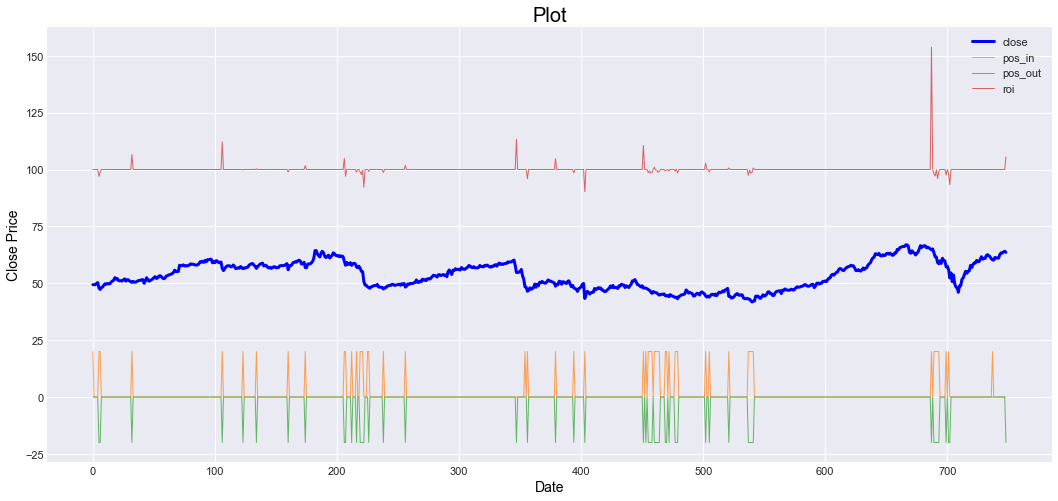

In [42]:
plot_df(bmy,['close','pos_in','pos_out','roi'],scale=[1,20,-20,100])

### note: here if pos_out mathces with pos_in, it is a 'fake' pos_out, because it means we 
### just exited position and took again, just for consistency, and trend was upward or we 
### didnt meet stop-loss criteria

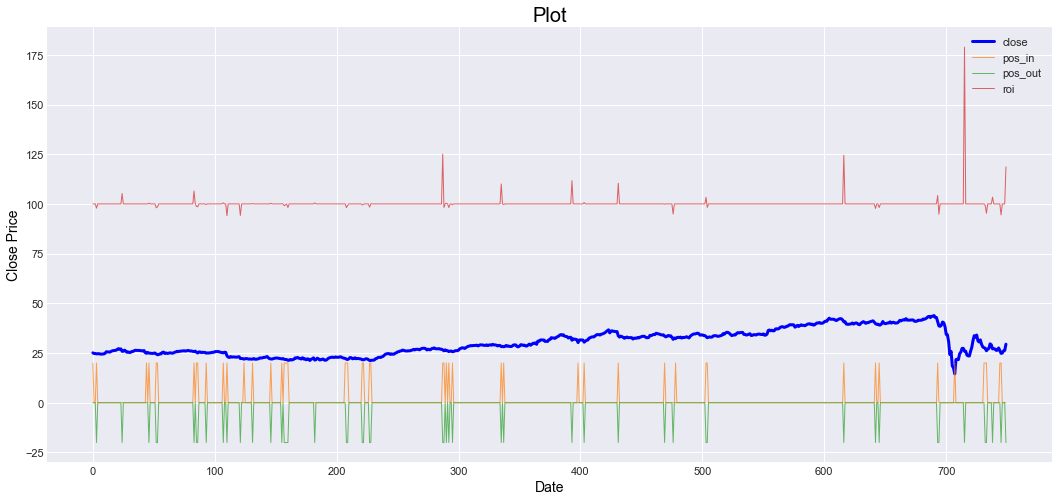

In [43]:
plot_df(ohi,['close','pos_in','pos_out','roi'],scale=[1,20,-20,100])

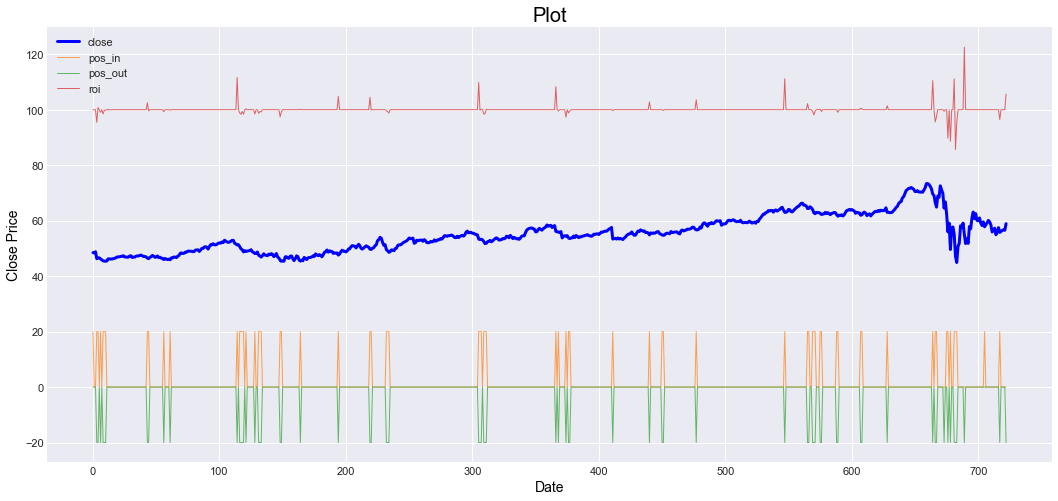

In [44]:
plot_df(evrg,['close','pos_in','pos_out','roi'],scale=[1,20,-20,100])

### 5.2. Test on S&P 500 data.
### Vanilla LogReg model for snp.

In [70]:
### Make numerical pipe
imputer = SimpleImputer()
scaler = RobustScaler()
pca = PCA(n_components=0.95, random_state = 42)
num_pipe = make_pipeline(imputer,scaler,pca)

### Make categorical pipe
encoder = WOEEncoder()
cat_pipe = make_pipeline(encoder)

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[('num', num_pipe, num_cols),
                  ('cat', cat_pipe, cat_cols)])

# Define model
model = LogisticRegression(class_weight='balanced', random_state=42,C=10,solver = 'newton-cg',
                          fit_intercept=True,penalty='l2')

# Make main pipeline
pipe_snp = make_pipeline(preprocessor, model)

# Get cross val score
scores = cross_val_score(pipe, X_snp, y_snp, cv=5, scoring='roc_auc')

# Print results
print(f'ROC-AUC scores:     {scores}')
print('-------------------')
print(f'Mean ROC-AUC score: {scores.mean()} +/-{scores.std()}')
print('-------------------')


ROC-AUC scores:     [0.94349206 0.92809524 0.91761905 0.9452381  0.94239316]
-------------------
Mean ROC-AUC score: 0.9353675213675213 +/-0.010776738555626894
-------------------


### Logreg Score Card model for snp.

In [73]:
# Make numerical pipe
imputer = SimpleImputer()
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
scaler = RobustScaler()
encoder = WOEEncoder()
pca = PCA(n_components=0.90, random_state = 42)
num_pipe = make_pipeline(imputer, binner, scaler, encoder)#,pca)

# Make categorical pipe
encoder = WOEEncoder()
cat_pipe = make_pipeline(encoder)

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[('num', num_pipe, num_cols),
                  ('cat', cat_pipe, cat_cols)])

# Define model
model = LogisticRegression(class_weight='balanced', random_state=42,C=10,solver = 'lbfgs',
                          fit_intercept=True,penalty='l2')

# Make main pipeline
pipe= make_pipeline(preprocessor, model)

# Get cross val score
scores = cross_val_score(pipe, X_snp, y_snp, cv=5, scoring='roc_auc')

# Print results
print(f'ROC-AUC scores:     {scores}')
print('-------------------')
print(f'Mean ROC-AUC score: {scores.mean()} +/-{scores.std()}')
print('-------------------')

ROC-AUC scores:     [0.94349206 0.92809524 0.91761905 0.9452381  0.94239316]
-------------------
Mean ROC-AUC score: 0.9353675213675213 +/-0.010776738555626894
-------------------


### Train test split for snp.

In [75]:
# from sklearn.model_selection import train_test_split
end = '2017-05-18'
start = '2017-05-19'

# for snp
X_train, X_test = X_snp[:end],X_snp[start:] 
y_train, y_test= y_snp[:end],y_snp[start:]  

snp_trained = snp[:end]
snp_tested = snp[start:]

### Train scorecard for snp.

In [77]:
pipe.fit(X_train, y_train)

y_hat_train = pipe.predict(X_train)
y_hat_test = pipe.predict(X_test)

prob_train = pipe.predict_proba(X_train)[:,1]
prob_test = pipe.predict_proba(X_test)[:,1]

print(f'ROC-AUC train_scores: {roc_auc_score(y_train, prob_train)}')
print('---------------------')
print(f'ROC-AUC test_scores: {roc_auc_score(y_test, prob_test)}')
print('---------------------')


ROC-AUC train_scores: 0.9799022783716661
---------------------
ROC-AUC test_scores: 0.9432249322493225
---------------------


In [108]:
thresh = 0.8
pred_train = (prob_train >= thresh).astype(np.int)
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      1512
         1.0       0.45      0.98      0.62        49

    accuracy                           0.96      1561
   macro avg       0.73      0.97      0.80      1561
weighted avg       0.98      0.96      0.97      1561



In [109]:
confusion_matrix(y_train,pred_train)

array([[1454,   58],
       [   1,   48]])

In [110]:
thresh = 0.8
pred = (prob_test >= thresh).astype(np.int)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       738
         1.0       0.23      0.55      0.33        20

    accuracy                           0.94       758
   macro avg       0.61      0.75      0.65       758
weighted avg       0.97      0.94      0.95       758



In [111]:
confusion_matrix(y_test,pred)

array([[702,  36],
       [  9,  11]])

### add predictions to data frame

In [112]:
end = '2017-05-18'
start = '2017-05-19'

snp_trained = snp[:end]
snp_trained['predicted']=pred_train

snp_tested = snp[start:]
snp_tested['predicted']=pred


In [114]:
snp_roi, snp_concat = roi_calc(snp_tested)

In [117]:
snp_concat

,date,ticker,open,high,low,close,predicted,pos_in,pos_out,roi,pct_loss,roi_cumprod
0,2017-06-27,^GSPC,2436.34,2440.15,2419.38,2419.38,1,1,0,1.000000,0.000000,1.000000
1,2017-06-28,^GSPC,2428.70,2442.97,2428.02,2440.69,0,0,0,1.000000,0.008808,1.000000
2,2017-06-29,^GSPC,2442.38,2442.73,2405.70,2419.70,0,0,0,1.000000,-0.008600,1.000000
3,2017-06-30,^GSPC,2429.20,2432.71,2421.65,2423.41,0,0,0,1.000000,0.001533,1.000000
4,2017-07-03,^GSPC,2431.39,2439.17,2428.69,2429.01,0,0,0,1.000000,0.002311,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
727,2020-05-18,^GSPC,2913.86,2968.09,2913.86,2953.91,0,0,0,1.000000,0.031501,1.135343
728,2020-05-19,^GSPC,2948.59,2964.21,2922.35,2922.94,0,0,0,1.000000,-0.010484,1.135343
729,2020-05-20,^GSPC,2953.63,2980.29,2953.63,2971.61,0,0,0,1.000000,0.016651,1.135343
730,2020-05-21,^GSPC,2969.95,2978.50,2938.57,2948.51,0,0,0,1.000000,-0.007774,1.135343


In [118]:
snp_roi

,roi
ticker,
^GSPC,1.49971


In [119]:
# compare with long term investment
snp_long = (snp_concat['close'][-1:].values/snp_concat['close'][:1].values)[0]

print(snp_long)

1.2215732956377252


#### Observation:
trades using model shows higher ROI than just long term investment: 1.4997 vs 1.2215